# Let's build GPT: from scratch, in code, spelled out. 

Following along with [Andrej Karpathy's video](https://www.youtube.com/watch?v=kCc8FmEb1nY)

## Basic bigram model for text generation

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

--2025-11-08 11:26:48--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2025-11-08 11:26:48 (8.09 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
with open("input.txt", "r") as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
# First 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# Unique characters in the text: this is the vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("all the unique characters: ", "".join(chars))
print("vocab size: ", vocab_size)

all the unique characters:  
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size:  65


In [6]:
# Mapping
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [
    stoi[c] for c in s
]  # encoder: take a string, output a list of integers
decode = lambda l: "".join(
    [itos[i] for i in l]
)  # decoder: take a list of integers, output a string

In [7]:
print(encode("What is six times nine? Forty two."))
print(decode(encode("What is six times nine? Forty two.")))

[35, 46, 39, 58, 1, 47, 57, 1, 57, 47, 62, 1, 58, 47, 51, 43, 57, 1, 52, 47, 52, 43, 12, 1, 18, 53, 56, 58, 63, 1, 58, 61, 53, 8]
What is six times nine? Forty two.


In [8]:
# An aside - try out encoding with tiktoken
import tiktoken

enc = tiktoken.get_encoding("gpt2")
print(enc.encode("What is six times nine? Forty two."))
print(enc.decode(enc.encode("What is six times nine? Forty two.")))

[2061, 318, 2237, 1661, 5193, 30, 38223, 734, 13]
What is six times nine? Forty two.


In [9]:
enc.n_vocab

50257

We can trade off the codebook size (vocabulary size) with the length of sequences. The larger the codebook, the more "chunks" of words it can represent in a single token of the vocabulary, the shorter the encoded sequences.

In [10]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])  # first 1000 characters encoded as integers

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [11]:
# Split the dataset into train and val sets

n = int(0.9 * len(data))  # first 90% will be train, rest val
print(f"Dataset size: {len(data)}, train size: {n}, val size: {len(data) - n}")
train_data = data[:n]
val_data = data[n:]

Dataset size: 1115394, train size: 1003854, val size: 111540


In [12]:
block_size = 8  # context length
train_data[: block_size + 1]  # first block_size+1 characters

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

The "block size" is also called the context length. It's the number of elements provided to the model in a single pass. 

Each of these blocks contains `block_size` examples for training, from length 1 to length `block_size`.

In [13]:
x = train_data[:block_size]
y = train_data[1 : block_size + 1]
for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print(f"when input is {context.tolist()} the target: {target}")

when input is [18] the target: 47
when input is [18, 47] the target: 56
when input is [18, 47, 56] the target: 57
when input is [18, 47, 56, 57] the target: 58
when input is [18, 47, 56, 57, 58] the target: 1
when input is [18, 47, 56, 57, 58, 1] the target: 15
when input is [18, 47, 56, 57, 58, 1, 15] the target: 47
when input is [18, 47, 56, 57, 58, 1, 15, 47] the target: 58


It's important to teach the transformer to recognize contexts of lengths 1 all the way to `block_size`.

It can only maintain `block_size` elements in memory. As the generated sequence extends beyond that limit, the truncated sequence is passed along.

In [14]:
torch.manual_seed(1337)
batch_size = 4  # how many independent sequences will we process in parallel?
block_size = 8  # what is the maximum context length for predictions?


def get_batch(split):
    """
    Generate a batch of data of inputs x and targets y
    """
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack(
        [data[i + 1 : i + block_size + 1] for i in ix]
    )  # Offset by one. These are the targets given the input from the first column to the current one in x.
    return x, y


xb, yb = get_batch("train")
print(f"inputs: {xb.shape}")
print(xb)
print(f"targets: {yb.shape}")
print(yb)

inputs: torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets: torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [15]:
for b in range(batch_size):  # iterate over the batch dimension
    for t in range(block_size):  # iterate over the time dimension
        context = xb[b, : t + 1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target: 1
when input is [52] the target: 58
when input is [52, 58] the target: 1
when input is [52, 58, 1] the target: 58
when input is [52, 58, 1, 58] the target: 46
when input is [52, 58, 1, 58, 46] the target: 39
when input is [52, 58, 1, 58, 46, 39] the t

In [16]:
print(xb)  # Input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=vocab_size
        )

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx)  # (B,T,C)

        if targets is None:
            loss = None
        else:
            # reshape the logits and targets to be (B*T, C) and (B*T) respectively
            # required by PyTorch cross_entropy loss function
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, _ = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B,C)
            # sample from the distribution
            # This is crucially different from a different tutorial I did before, where I took the argmax.
            # Taking the argmax would make the model deterministic, and it would always produce the same
            # sequence given the same context.
            idx_next = torch.multinomial(probs, num_samples=1)  # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B,T+1)
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(
    decode(
        m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[
            0
        ].tolist()
    )
)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [18]:
# If you directly compute the negative log-likelihood of a totally random model, it would be

optimal_loss = -torch.log(torch.tensor(1.0 / vocab_size))
optimal_loss

tensor(4.1744)

This indicates that the current model is not perfectly random. It has some "entropy".

In [19]:
# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [20]:
from tqdm.notebook import tqdm

batch_size = 32
losses = []
for steps in tqdm(range(25000)):
    # sample a batch of data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = m(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(steps, loss.item())


  0%|          | 0/25000 [00:00<?, ?it/s]

24999 2.4316647052764893


In [21]:
import plotly.express as px

px.line(
    x=list(range(len(losses))),
    y=losses,
    labels={"x": "step", "y": "loss"},
    title="Training loss",
).show()

That's a ghastly bit of overfitting.

In [22]:
print(
    decode(
        m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[
            0
        ].tolist()
    )
)


Cl, IZEEDUENGonthe t l me's angice;
Thewareratulyendutonde 's flie,
fr arnd ic-mybem t m'dsent ee, blouged fere fearau se fofouriey'd!
LANEThellld ogo withend tequ
Y ldill, totooousothive wdd nctonasngin mm se mpll,
WA st?

Whins t'eng t rere t inchyig y;
Y:
S:
RDYOn h cas re be I it? meswed,
Noun
Thou that alizathive ly

Premo Twe HAus hyon,
Hep s taldr g d wh h ju pr gurkeortwhin Whakil te d;
Berenu ad-priou y!
Buerstoo, engin, anifiterit p,
isthey thopis'd
Bu?
He thilere apre thior ane; ofar 


This really is the simplest possible model. It uses a single letter of "history" to generate the next token.

At the very least, it's learned the general structure of a play, with character names, a colon, and dialogue following. It even learned the word "Thou", so it's certainly Shakespearean.

## The mathematical trick in self-attention

In [23]:
# consider the following toy example:

torch.manual_seed(1337)
B, T, C = 4, 8, 2  # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

### A note on embeddings and channels



In real embeddings, each token is converted into a vector belonging to the vector space of an *embedding dimension*. `C` is thus the size of the vector representing each token. 

In the [bigram model example](#basic-bigram-model-for-text-generation), we're using the most basic kind of embedding - converting a character into an integer. For this file, `C = 1`.

For the above toy example, `C = 2` means that the input text was mapped into two-dimensional tokens.

### Attention (masking)

We're trying to compute the interaction between every token and all the tokens *preceding* it. 

Subsequent tokens are "future" tokens. A model cannot learn to predict the current token using future inputs.

#### Simple attention mechanism: averaging


We want $x[b, t] = mean_{i<=t} (x[b, i])$

This is also known as a bag of words. Each location contains a 'word', and we're averaging those together.

In [24]:
xbow = torch.zeros((B, T, C))  # Bag-of-words
for b in range(B):
    for t in range(T):
        # Average across all preceding time steps
        xprev = x[b, : t + 1]  # (t, C) Includes the current time step
        xbow[b, t] = torch.mean(xprev, dim=0)  # Average across the time dimension


This is super inefficient. Nobody likes `for` loops. Let's do matrix multiplications instead. 

#### Optimized self-attention: matrix multiplication

##### Background


In [25]:
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b

print(f"{a=}")
print("--")
print(f"{b=}")
print("--")
print(f"{c=}")

a=tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


Since all the rows of `a` are simply ones, this is just a simple sum of the columns of `b`.

By turning `a` into a lower triangular matrix, we can mask the entries of `b` in the exact method we want - based on the time dimension. All entries up to and including the current time step are set to `1`, all others are `0`.

In [26]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b

print(f"{a=}")
print("--")
print(f"{b=}")
print("--")
print(f"{c=}")

a=tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


This produces a sum, but we want an average. We can achieve that by normalizing the rows of `a` so that the values sum to `1`. Alternatively, do this matrix multiplication and do a vector division by the sum of the `1`s in each row of `a`. 

###### A note on `keepdim`

In [27]:
a = torch.tril(torch.ones(3, 3))
torch.sum(a, dim=1), torch.sum(a, dim=1, keepdim=True)

(tensor([1., 2., 3.]),
 tensor([[1.],
         [2.],
         [3.]]))

The first tensor is a simple length-3 vector. Dividing by that doesn't normalize the rows of `a`, it simply divides each element by the corresponding element in the vector. 

To get the behavior we want, we want the sum to be broadcast to the time dimension. `keepdim` preserves the time dimension. Each row of `a` should be divided by the value associated with that time step. 

In [28]:
a / torch.sum(a, dim=1), a / torch.sum(a, dim=1, keepdim=True)

(tensor([[1.0000, 0.0000, 0.0000],
         [1.0000, 0.5000, 0.0000],
         [1.0000, 0.5000, 0.3333]]),
 tensor([[1.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000],
         [0.3333, 0.3333, 0.3333]]))

In [29]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, dim=1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b

print(f"{a=}")
print("--")
print(f"{b=}")
print("--")
print(f"{c=}")

a=tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


##### Vectorizing the previous `for` loop

In [30]:
# Create the weights matrix of the size specified by the time dimension.
wei = torch.tril(torch.ones(T, T))
wei = wei / torch.sum(wei, dim=1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [31]:
xbow2 = wei @ x  # (T, T) @ (B, T, C)
# PyTorch implicitly adds in the batch dimension to broadcast correctly
# (T, T) --> (B, T, T) @ (B, T, C) = (B, T, C)

# And we can confirm that the two methods produce the same result
torch.allclose(xbow, xbow2, atol=1e-6)

True

In [32]:
xbow[0] - xbow2[0]

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.9802e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  7.4506e-09],
        [-7.4506e-09,  0.0000e+00],
        [ 7.4506e-09, -1.4901e-08],
        [ 0.0000e+00,  0.0000e+00]])

##### Vectorized: Using softmax

In [33]:
tril = torch.tril(torch.ones(T, T))
tril


tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [34]:
wei = torch.zeros(T, T)
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
# Basically codifies the idea that future tokens cannot interact with the current time stamp.
wei = wei.masked_fill(tril == 0, float("-inf"))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [36]:
# Normalize the weights to apply to the input matrix.
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [37]:
xbow3 = wei @ x
torch.allclose(xbow, xbow3, rtol=1e-4)

True

### Self-attention

In [56]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32  # batch, time, channels. 32-dimensional information at each token.
x = torch.randn(B, T, C)

tril = torch.tril(torch.ones(T, T))
# These are the 'affinities' between the tokens. Every token has the same affinity with every previous token (and itself).
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)
out = wei @ x

out.shape

torch.Size([4, 8, 32])

We do not necessarily want the affinities to be uniform. Each token may find its preceding tokens (and itself) possibly more or less interesting. This *should* be data-dependent. 

From each token, we want to get a *query* vector and a *key* vector. 

The query is dot-producted with all the keys to get `wei`.

#### Implementation of a single self-attention head


In [62]:
head_size = 16
# Within the attention block, there is a latent space of this dimension.
# The token-embedding dimension is mapped into the dimension inside this attention block.

# fmt: off
key = nn.Linear(C, head_size, bias=False)   # A representation of what the token in this position is offering as a means of identification.
query = nn.Linear(C, head_size, bias=False) # A representation of what the token in this position is looking to understand about other tokens.
value = nn.Linear(C, head_size, bias=False) # A representation of what the token in this position is providing as its 'information' content.
# fmt: on

k = key(x)  # (B, T, head_size)
q = query(x)  # (B, T, head_size)
v = value(x)  # (B, T, head_size)

All these keys, queries, and values, to this point, are created independently from every token. There is no relationship between them yet.

In [ ]:
# Affinities
wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) --> (B, T, T)
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)
wei


tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

In [65]:
out = wei @ v

out.shape

torch.Size([4, 8, 16])

The output here is in the dimension of the attention head's latent space. It needs to be put back into the size of `x`.

#### Directed graph representation of the attention block

Each token interacts with itself and all its previous tokens.

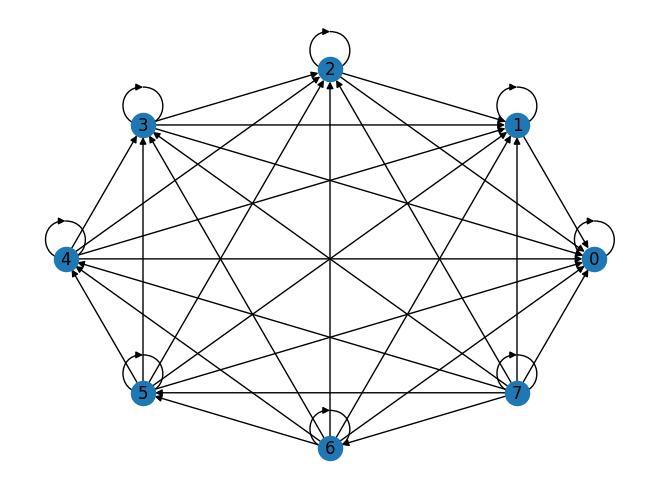

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(directed=True)
block_size = 8
G.add_edges_from([(ch, chh) for ch in range(block_size) for chh in range(ch + 1)])

nx.draw_circular(
    G,
    labels={x: str(x) for x in range(block_size)},
)
plt.show()
